In [117]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import expon
from sklearn.metrics import r2_score
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates
import re
%matplotlib inline
warnings.filterwarnings("ignore")

In [119]:
# our goal is to clean the data if needed, and conctruct a pipelines with which we will be able to work further
# pipelines will include normalization, outliers detection and the models itself
# for our further analysis we will select two models linear regression and regressino tree

In [120]:
df = pd.read_csv("hour.csv")

In [121]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,springer,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,springer,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,springer,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,springer,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,springer,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,springer,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,springer,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,springer,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,springer,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [122]:
def rep(x): # to select the yeat-month from year-month-day
    s = re.findall(r"\d{4}-\d{2}",x)[0]
    return re.sub(r"\d{4}-\d{2}-\d{2}", s, x)

In [123]:
df["dteday"] = df["dteday"].apply(lambda x : rep(x))

In [124]:
df["dteday"] = df["dteday"].apply(lambda x : matplotlib.dates.date2num(datetime.strptime(x, "%Y-%m"))) # convert 

In [125]:
s = pd.DataFrame(df.groupby("dteday")["cnt"].mean()).reset_index() # group by data

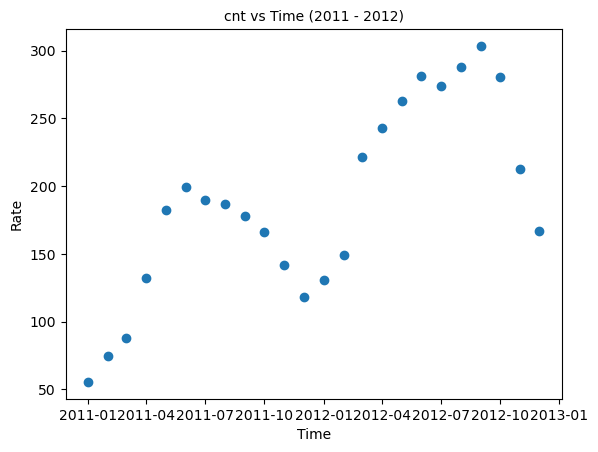

In [126]:
plt.plot_date(s["dteday"],s["cnt"])
plt.title('cnt vs Time (2011 - 2012)', fontdict=dict(size=10))
plt.ylabel('Rate')
plt.xlabel('Time')
plt.show()

In [127]:
def group_and_plot(x,y="cnt",t = True): # special func fro plotting purposes
    if t:
        s = pd.DataFrame(df.groupby(x)[y].mean()).reset_index()
        plt.bar(s[x],s[y])
    else:
        plt.scatter(x,y)
        plt.show()

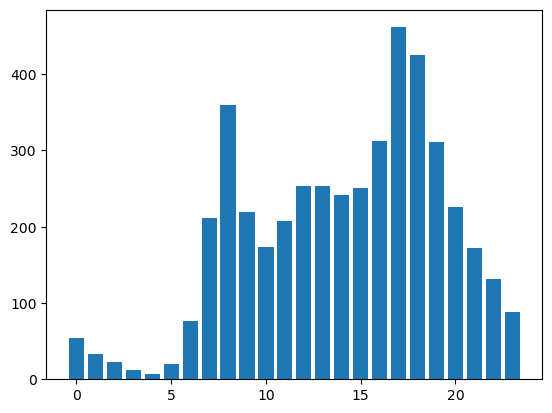

In [128]:
group_and_plot("hr","cnt")

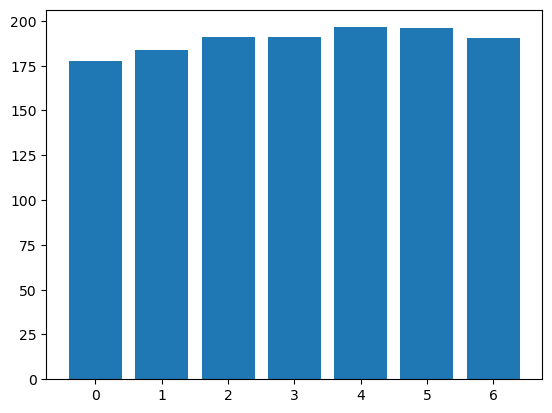

In [129]:
group_and_plot("weekday","cnt")

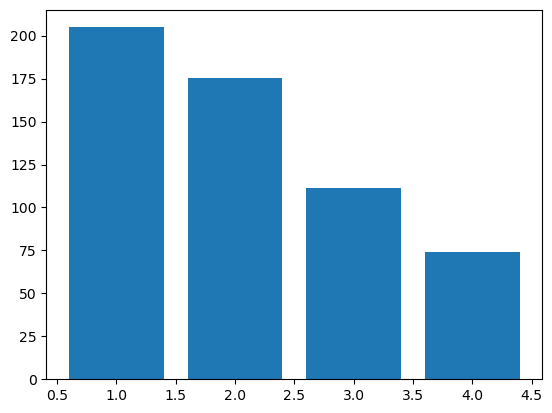

In [130]:
group_and_plot("weathersit","cnt")

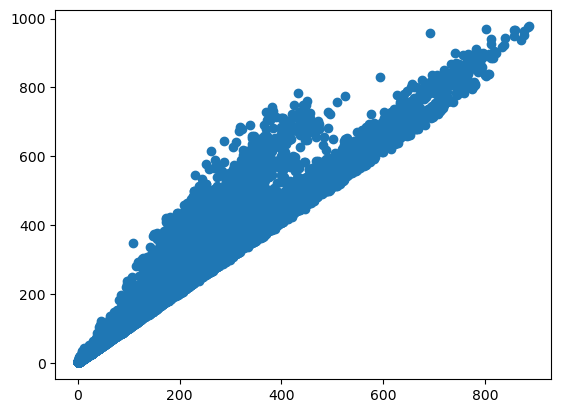

In [131]:
group_and_plot(df["registered"],df["cnt"],False)

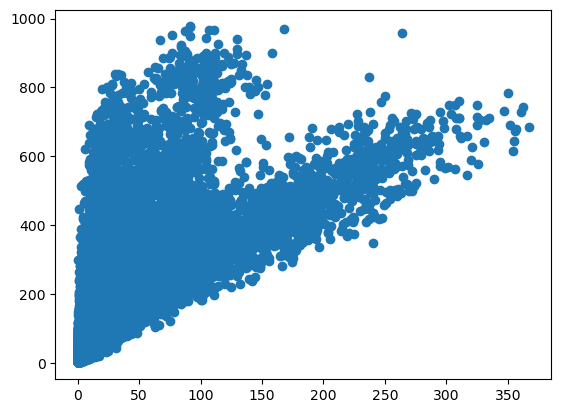

In [132]:
group_and_plot(df["casual"],df["cnt"],False)

In [133]:
df.describe() # many of our variables are categorical...

,instant,dteday,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,15326.489211,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,209.838339,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,14975.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,15156.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,15340.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,15522.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,15675.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [134]:
df.skew() # we can use bulit in pandas function to assess the skewness for each variable that we have

instant       0.000000
dteday       -0.001435
yr           -0.010243
mnth         -0.009253
hr           -0.010680
holiday       5.638538
weekday      -0.002998
workingday   -0.785258
weathersit    1.228047
temp         -0.006021
atemp        -0.090429
hum          -0.111287
windspeed     0.574905
casual        2.499237
registered    1.557904
cnt           1.277412
dtype: float64

In [135]:
# plus sign means that we have right skew, that is when data "tail" extends to the right, negative sign means the opposite, 
# tail extends to the left. When we have right skew, our mode is less than mean, for left skew the opposite - mean is less than mode

# 

In [136]:
# From our dataset we can see that we have a lot of categorical values (like binary format: 0 or 1)
# There is no need to actually normalize them, since they represent the count 
# The whole purpose of normalization is to offset the difference between features, to make the, equally importnant to our ML model

# On the other hand, with random variables (either discrtee or continuos) we can be sure, that normalization will not make things worse
# in fact, it is required to maintain good results for training models! 

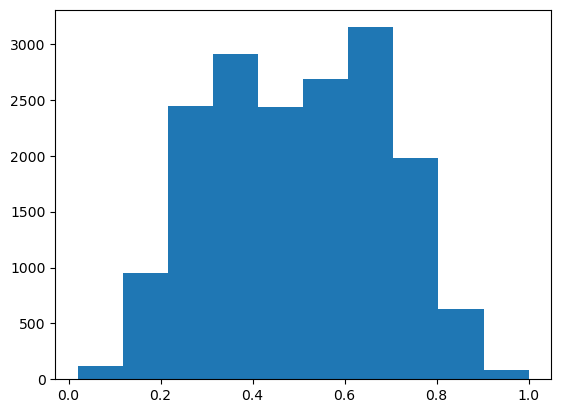

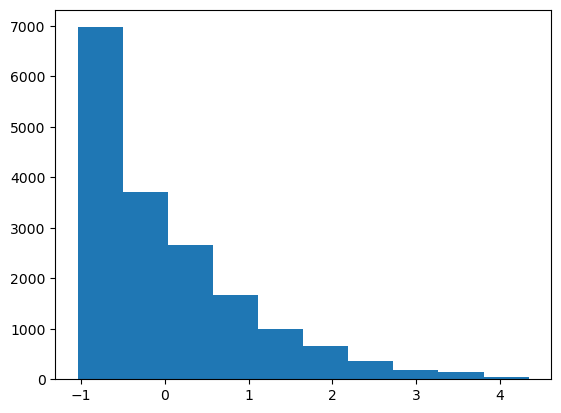

temp



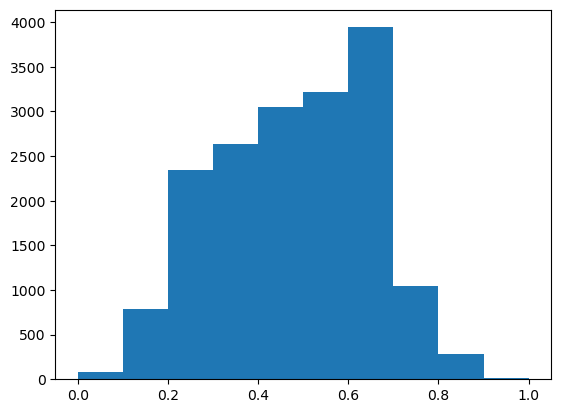

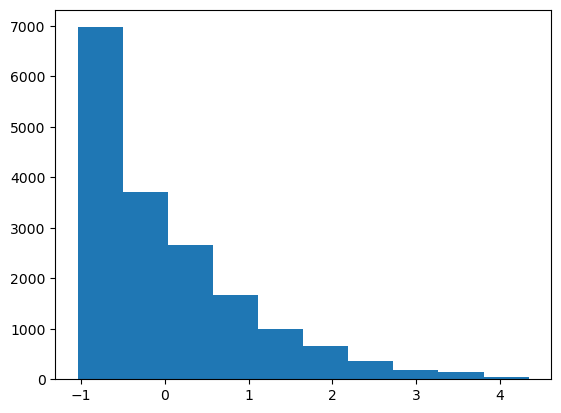

atemp



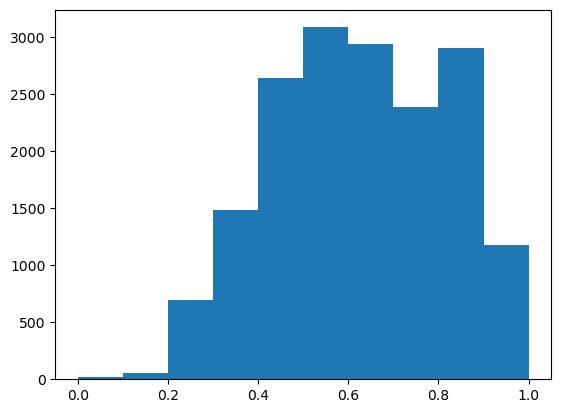

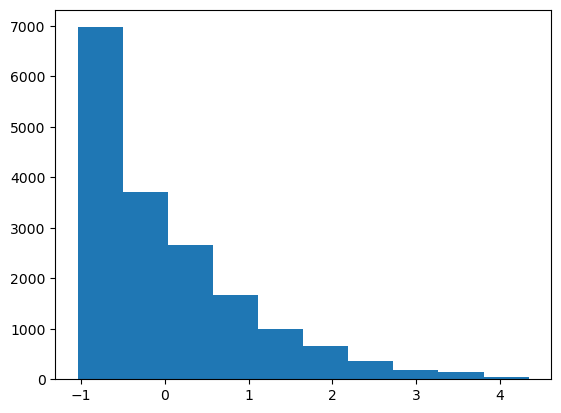

hum



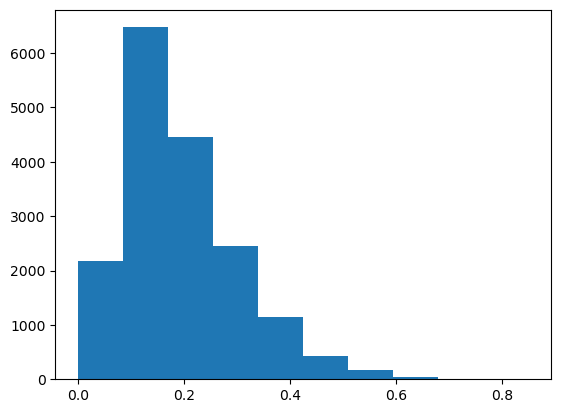

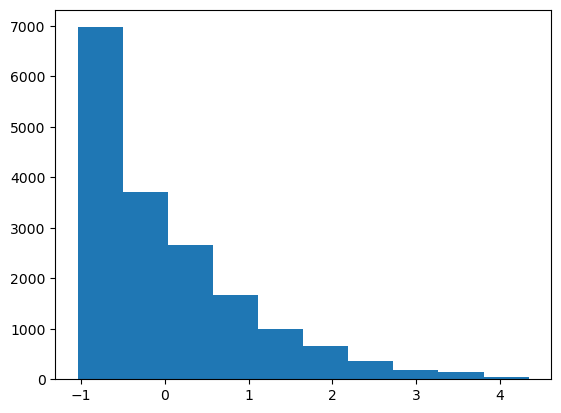

windspeed



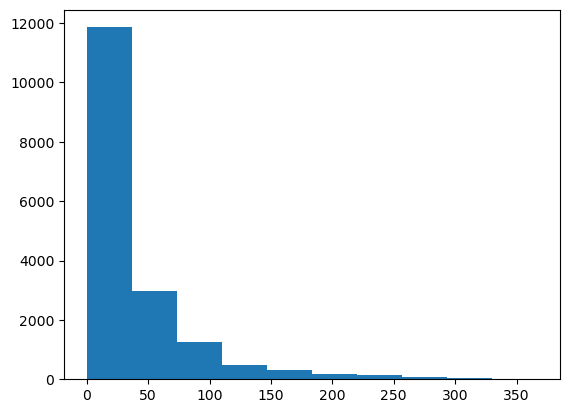

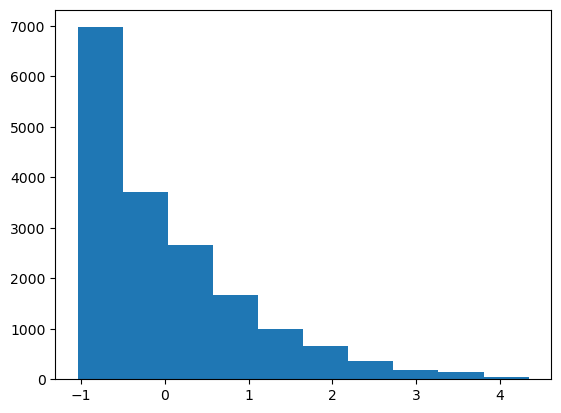

casual



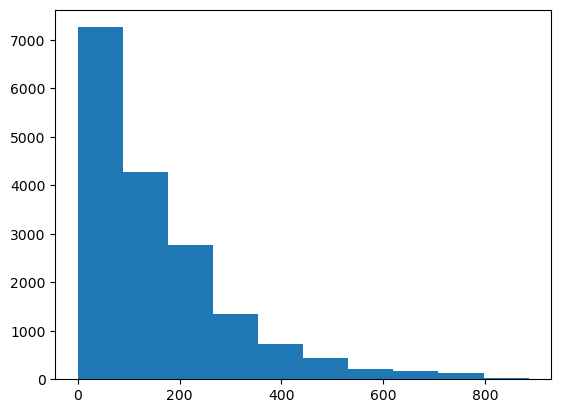

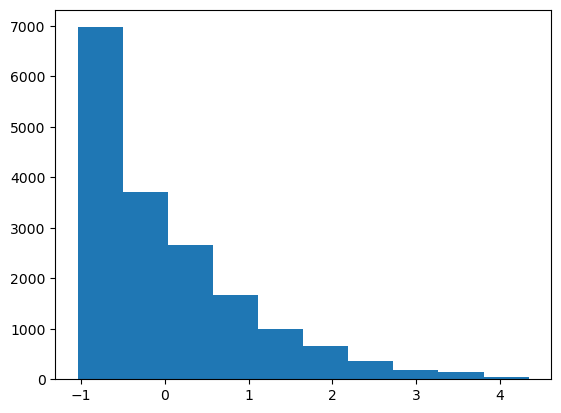

registered



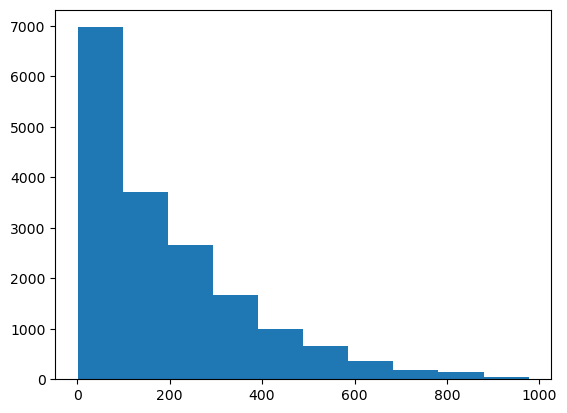

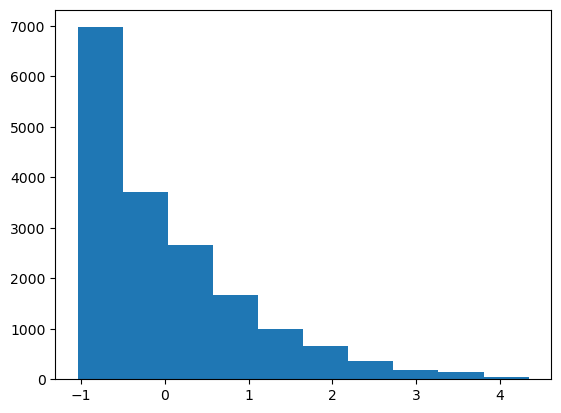

cnt



In [137]:
for i  in range(10, len(df.columns)):
    column = df.columns[i]
    plt.hist(df[column])
    plt.show()
    x = StandardScaler()
    y = x.fit_transform(df[["cnt"]])
    plt.hist(y)
    plt.show()
    print(column)
    print()

In [138]:
# as you can see, with scaling we fetch each variable to the single standard: that is random variable distributed normally,
# with mean of 0 and variance of 1. hence, 99% of values for each variable will be spreaded from -3 to 3 (3 sigme rule)
# As a result, we will be more efficient when comparing the values of different features since they are in the same "boat" now.

In [139]:
# in the code for milestone 3, I included normalization process in all pipelines, meaning that before training the model,
# our variables will be normalized!

# but we have to make one change. In our pipeline, scaler will normalize every single column, but as we concluded before,
# we would like to normalize only numeric features, not categorical. For this purpose, we will create our own class for scaling
# which will scale only the required columns

In [140]:
class my_own_scaler(BaseEstimator,TransformerMixin):
    def __init__(self,inds):
        self.norm = StandardScaler() # create scaled
        self.inds = inds # we pass the indicies of the column we would like to normalize
    
    def fit(self,X,y=None):
        self.one = [] # now, in fit methods, we will create a matrix of corresponding column, which will be normalized later
        
        #print(X)
        for row in X:
            #print(row)
            change = []
            for i in self.inds:
                change.append(row[i])
            self.one.append(change)
                
        self.norm.fit(self.one) # we train our scaler ONLY on these columns, not the whole dataframe
        return self
    
    def transform(self,X,y=None):
        new =  self.norm.transform(self.one) # now, in transform we perform transform :)
        opora = self.inds[0] 
        
        # one crucial detail: we have indices of columns we would like ot change, like self.inds = [6,7,8,9]
        # but, each row in our normalized matrix (new) has indicies 0,1,2,3. We have to map these indicies to the original indicies in the dataframe
        # for this, each time we access the index, like 6, we will subtract the value of the first index (original).
        # in our example, the first value is 6. So 6-6 = 0. Then 7: 7-6 = 1 Then 8: 8-6 = 2 and so on.
        
        c = 0 # index of the row
        for row in X: # now, for each row
            for i in self.inds: # # we will change the position (column) with index i
                new_ind = i-opora # map the index
                row[i] = new[c][new_ind]
            c += 1

        return X # finally, return chnaged dataframe
    
    
# in the end of the notebook you can find a visible example of such performace!
        

In [141]:
class OutlierRemover(BaseEstimator,TransformerMixin): # our own class to remove outliers - we will insert it to the pipeline
    
    def __init__(self,factor=1.5):
        self.factor = factor # higher the factor, extreme would be the outliers removed.
        
    def outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr)) 
        self.upper_bound.append(q3 + (self.factor * iqr))
        self.median.append(X.median())

    def fit(self,X,y=None): # for each coulmn we will append corresponding boundary and the median value
        self.median = []
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.outlier_detector)
        return self
    
    def transform(self,X,y=None):
        X = pd.DataFrame(X).copy()
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy()
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = self.median[i] # replace outliers with the median
            X.iloc[:, i] = x

        return X

In [142]:
np.count_nonzero(df.isnull()) # all clean, no nans

0

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  float64
 2   season      17379 non-null  object 
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(5), int64(11), object(1)
memory usage: 2.3+ MB


In [144]:
# we see that season column is str (object), we will convert it to numeric

In [145]:
le=LabelEncoder()
df["season"]= le.fit_transform(df["season"])
df.drop(["instant","dteday"],axis=1,inplace=True)  # common sense tells us that we dont really need index and date columns

In [146]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [147]:
df.info() # now its int 32

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int32  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  casual      17379 non-null  int64  
 13  registered  17379 non-null  int64  
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int32(1), int64(10)
memory usage: 1.9 MB


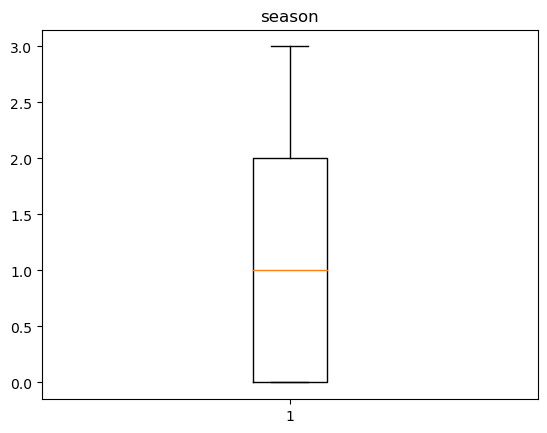

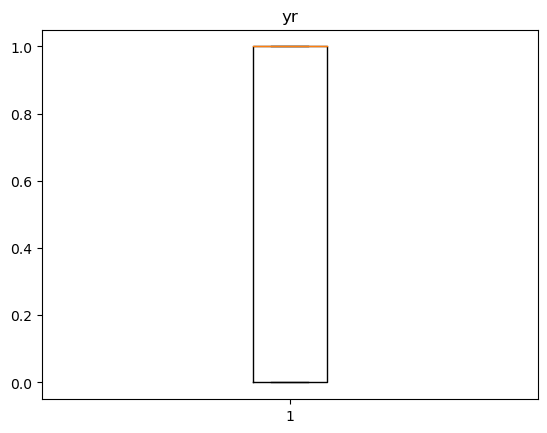

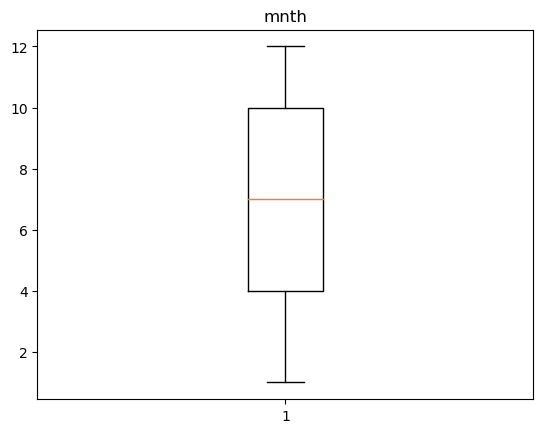

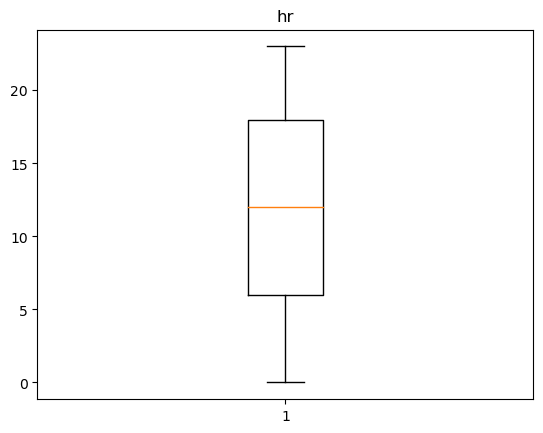

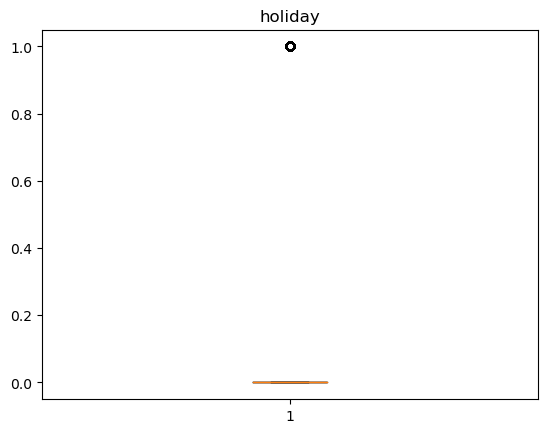

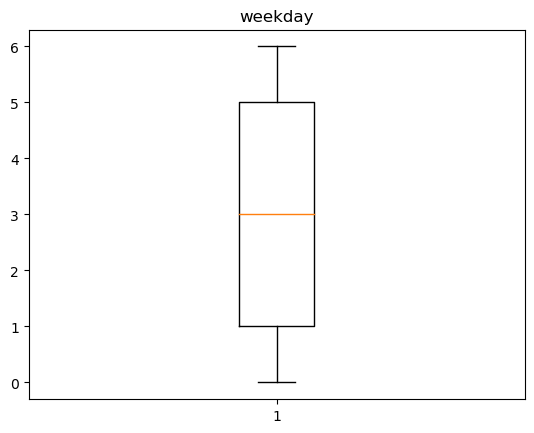

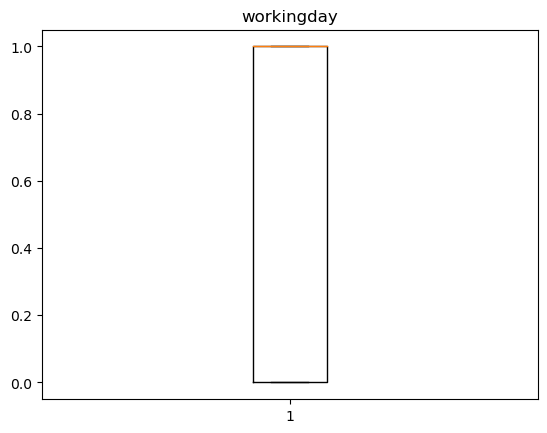

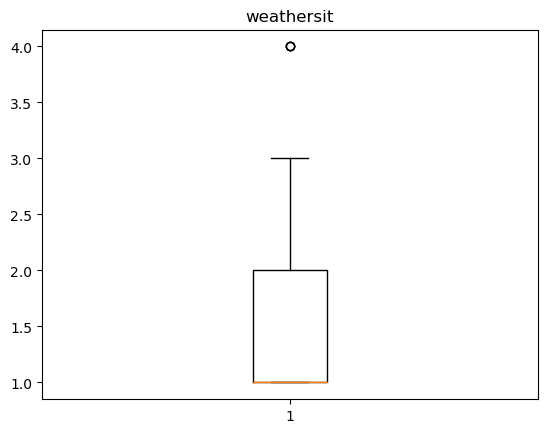

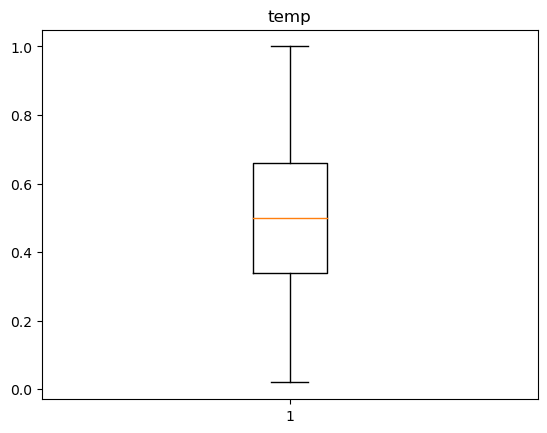

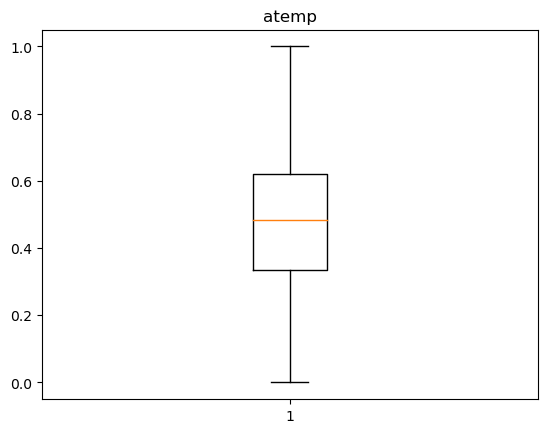

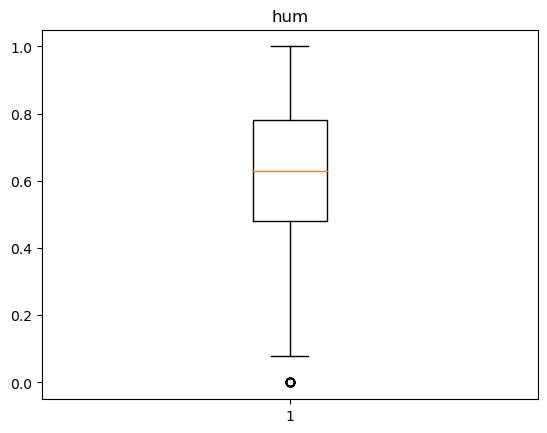

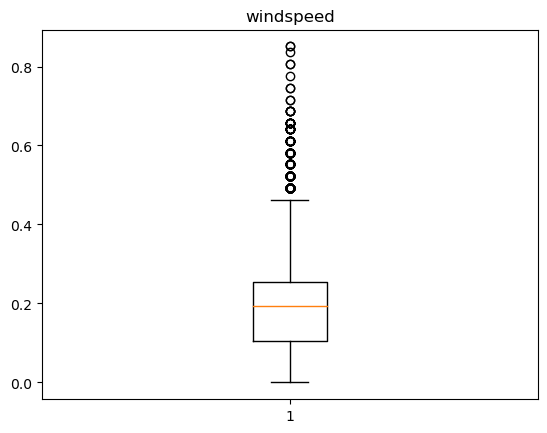

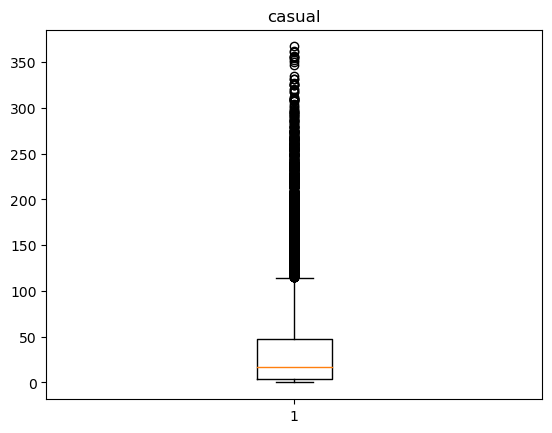

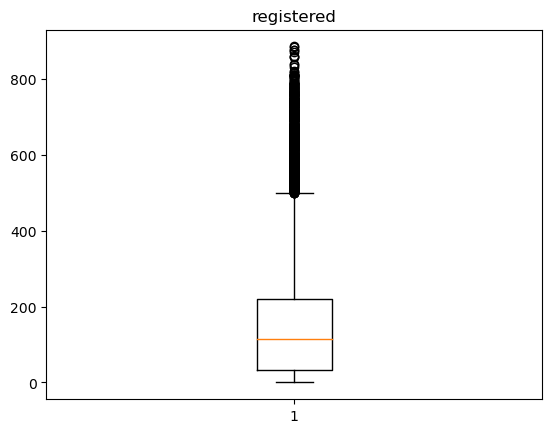

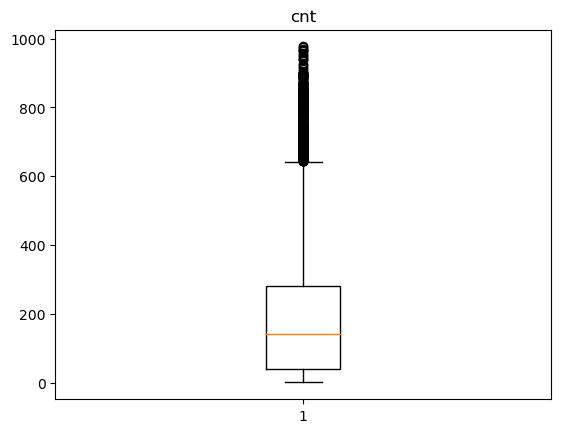

In [148]:
for i in range(len(df.columns)): # check for the outliers
    col = df.columns[i]
    ar = df[col]
    plt.boxplot(ar)
    plt.title(col)
    plt.show()

In [149]:
# we see that some attributes have a bucnh of outliers, thus we will have to deal with them in out pipelines

In [150]:
df.corr() # lets observe how our features are related to target lineary

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
season,1.000000,-0.006572,0.325234,-0.001354,0.014444,-0.009910,-0.007303,0.072684,-0.361958,-0.335197,0.082580,-0.008939,-0.064472,0.005234,-0.013157
yr,-0.006572,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.325234,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.001354,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014444,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,-0.009910,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.007303,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,0.072684,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,-0.361958,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772
atemp,-0.335197,0.039222,0.208096,0.133750,-0.030973,-0.008821,0.054667,-0.105563,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.400929


In [151]:
# now, because we will use multiple linear regression, we dont want to encounter multicollinearity - effect when 
# independent variables in fact have some correlation - that might result in poor modeling results, like
# when our weights might be inadequately large. hence, we will use ridge multiple regression, so that our model
# could set the weights such that their sum will be minimal.

# basically, tha task is the following:

# <weights, features> - bias + C * sum(weights^2) -> min, instead of <weights, features> - bias -> min

# C is our hyperparametr, degree of accounting for this amount. We will have to find the best one with GridSearch method


In [152]:
outlier_remover = OutlierRemover()

sl = my_own_scaler(list(range(7,15)))

ct = ColumnTransformer(transformers=[['outlier_remover',OutlierRemover(),list(range(df.shape[1]))]]) 


data_pipe = Pipeline(steps=[["outlier_removal",ct],['scalar', sl]])

d = data_pipe.fit_transform(df)


df = pd.DataFrame(d, columns = df.columns)



In [153]:
df # normalized and cleaned

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,-0.665290,-1.334648,-1.093281,0.949621,-1.651213,-0.806714,-1.044547,-1.019519
1,1.0,0.0,1.0,1.0,0.0,6.0,0.0,-0.665290,-1.438516,-1.181732,0.897437,-1.651213,-0.619156,-0.880010,-0.862487
2,1.0,0.0,1.0,2.0,0.0,6.0,0.0,-0.665290,-1.438516,-1.181732,0.897437,-1.651213,-0.731691,-0.923309,-0.914831
3,1.0,0.0,1.0,3.0,0.0,6.0,0.0,-0.665290,-1.334648,-1.093281,0.636514,-1.651213,-0.806714,-1.070526,-1.039148
4,1.0,0.0,1.0,4.0,0.0,6.0,0.0,-0.665290,-1.334648,-1.093281,0.636514,-1.651213,-0.919249,-1.148464,-1.117665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1.0,1.0,12.0,19.0,0.0,1.0,1.0,0.900962,-1.230779,-1.269602,-0.146254,-0.170537,-0.506621,-0.221866,-0.345588
17375,1.0,1.0,12.0,20.0,0.0,1.0,1.0,0.900962,-1.230779,-1.269602,-0.146254,-0.170537,-0.619156,-0.455680,-0.541879
17376,1.0,1.0,12.0,21.0,0.0,1.0,1.0,-0.665290,-1.230779,-1.269602,-0.146254,-0.170537,-0.656667,-0.438361,-0.535336
17377,1.0,1.0,12.0,22.0,0.0,1.0,1.0,-0.665290,-1.230779,-1.181732,-0.354993,-0.440160,-0.431598,-0.741454,-0.725083


In [154]:
# for regression, lets try to choose the most lineary correlated values in our dataset
# for tree we dont really care about linearity, hence we can choose all attributes

In [155]:
data1 = df.loc[:, ["registered","casual","temp","atemp","hr","hum", "cnt"]]
data2 = df.iloc[:, 0:df.shape[1]]

In [156]:
# we will search for the optimal hyperparamethrs with our grids


param_grid1 = {'regressor__alpha':expon(loc=0, scale=4)}

param_grid2 = {'tree__ccp_alpha':expon(loc=0, scale=2)} 


# for ccp alpha paramter (post pruning), we will use a whole distr, hence it will be randomized search


In [157]:


pipe1 = Pipeline(steps = [['regressor',Ridge()]])
pipe2 = Pipeline(steps = [['tree',tree.DecisionTreeRegressor()]])

#initialize our grid searches

gs1 = RandomizedSearchCV(estimator= pipe1, param_distributions  = param_grid1, scoring='neg_root_mean_squared_error', cv = 10,random_state=42)
gs2 = RandomizedSearchCV(estimator= pipe2, param_distributions  = param_grid2, scoring='neg_root_mean_squared_error', cv = 10, random_state=42)


In [158]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1.iloc[:, 0:data1.shape[1]-1], data1["cnt"], test_size=0.3, random_state=100)
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2.iloc[:, 0:data2.shape[1]-1], data2["cnt"], test_size=0.3, random_state=42)

In [159]:
# now, lets finally run the grids on our training sets to fidn optimal hypers (it might take a bit of time to run)

In [160]:
gs1.fit(X_train1,y_train1) #note, this may take some time to run
reg_params = gs1.best_params_

In [161]:
gs2.fit(X_train2,y_train2)
tree_params = gs2.best_params_

In [162]:
reg_params

{'regressor__alpha': 5.266982774181797}

In [163]:
tree_params

{'tree__ccp_alpha': 0.11967753721736135}

In [164]:
# now, we have what we need to train the models! we can use these hypers and adjust our pipelines with them and then train/test the models

In [165]:
def analyze_class_with_metrics(model,x,y,folds = 10): # display all mettrics for the pipelines
    d = x
    adj_r_2 = lambda r: 1 - (1-r) * ( len(y) - 1 ) / ( len(y) - d.shape[1] - 1 )
    #print(f"model: {model.steps[-1][0]}")
    scores = cross_val_score(model, d, y,scoring="r2", cv=folds).mean() # use cross valid since our dataset is not that big
    scores1 = cross_val_score(model, d, y,scoring="neg_mean_squared_error", cv=folds).mean()
    scores2 = cross_val_score(model, d, y,scoring="neg_root_mean_squared_error", cv=folds).mean()
    scores3 = adj_r_2(scores)
    print(f"mean r2: {scores}\nadjusted mean r^2: {scores3}\nneg mean mse: {scores1}\nneg mean rmse: {scores2}")
    return 

In [166]:
# update the params


alpha = reg_params["regressor__alpha"]


ccp = tree_params["tree__ccp_alpha"]

pipe1 = Pipeline(steps=[['regressor',Ridge(alpha=alpha)]]) 
pipe2 = Pipeline(steps=[['tree',tree.DecisionTreeRegressor(ccp_alpha=ccp)]])





In [167]:
# evaluate on the training set

In [168]:
analyze_class_with_metrics(pipe1, X_train1, y_train1)

mean r2: 0.8055479889182596
adjusted mean r^2: 0.8054520264189595
neg mean mse: -0.19681534114354138
neg mean rmse: -0.44160535798362527


In [169]:
analyze_class_with_metrics(pipe2, X_train2, y_train2)

mean r2: 0.7396327603045538
adjusted mean r^2: 0.7393327486703369
neg mean mse: -0.26194617530392944
neg mean rmse: -0.5110447691347677


In [170]:
# whats for the test set?

In [171]:

pipe2.fit(X_train2,y_train2)
hats = pipe2.predict(X_test2)
r2_score(y_test2,hats)

0.7438261816946308

In [172]:
pipe1.fit(X_train1,y_train1)
hats = pipe1.predict(X_test1)
r2_score(y_test1,hats)

0.8138637046292505

In [173]:
from sklearn.ensemble import RandomForestRegressor # example of random forest
regr = RandomForestRegressor(max_depth=5, random_state=0)
analyze_class_with_metrics(regr, X_train1, y_train1)

mean r2: 0.8692070136261838
adjusted mean r^2: 0.8691424669969485
neg mean mse: -0.13213135231017376
neg mean rmse: -0.3625167273335209


In [174]:
 preds = pipe1.predict(df[["registered","casual","temp","atemp","hr","hum"]]) # predictions

In [175]:
df["prediction"]= preds

In [176]:
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,prediction
0,1.0,0.0,1.0,0.0,0.0,6.0,0.0,-0.66529,-1.334648,-1.093281,0.949621,-1.651213,-0.806714,-1.044547,-1.019519,-1.077372
1,1.0,0.0,1.0,1.0,0.0,6.0,0.0,-0.66529,-1.438516,-1.181732,0.897437,-1.651213,-0.619156,-0.880010,-0.862487,-0.929220
2,1.0,0.0,1.0,2.0,0.0,6.0,0.0,-0.66529,-1.438516,-1.181732,0.897437,-1.651213,-0.731691,-0.923309,-0.914831,-0.971605
3,1.0,0.0,1.0,3.0,0.0,6.0,0.0,-0.66529,-1.334648,-1.093281,0.636514,-1.651213,-0.806714,-1.070526,-1.039148,-1.073057
4,1.0,0.0,1.0,4.0,0.0,6.0,0.0,-0.66529,-1.334648,-1.093281,0.636514,-1.651213,-0.919249,-1.148464,-1.117665,-1.142719
